# Von Mises-Fisher distribution

Our goal is to fit a Von Mises-Fisher distribution ("Spherical Gaussian") to some data.
We will follow [Wikipedia's derivations](https://en.wikipedia.org/wiki/Von_Mises–Fisher_distribution)

Our input data is a collection of $N$ directions $x_i \in \mathbb{R}^3$, each with a weight $w_i$.
Let the weights be normalized ahead of time to have an average of one, that is $\sum_i w_i = N$.

We will produce the maximum likelihood estimate of the distribution's parameters, $\mu \in \mathbb{R}^3$ (central direction), and $\kappa \in \mathbb{R}$ (variance).
Note that each direction $x_i$ satisfies $||x_i|| = 1$, and further $||\mu|| = 1$.

In [87]:
# Handle imports.
%matplotlib inline
import scipy.special
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
def scatter3d(points):
    fig = plt.figure()
    ax = Axes3D(fig)
    # Mark the origin with a red X.
    ax.scatter([0], [0], [0], marker="x", color="red")
    # Mark the points.
    ax.scatter(*zip(*x))

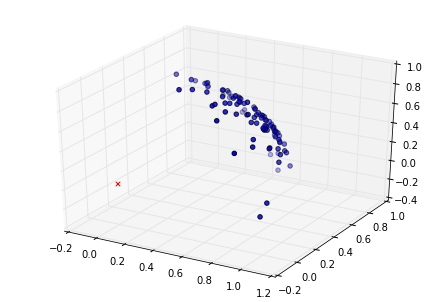

In [80]:
# Generate some random input data that's over in the true_offset direction.
true_offset = (1, 1, 1)
noise_magnitude = 0.5
N = 100
x = [noise_magnitude * np.random.normal(size=3) + true_offset for _ in xrange(N)]
# Normalize the points onto the sphere.
x = np.array([i / np.linalg.norm(i) for i in x])
# Generate some random weights between 0 and 1 for the points.
w = np.array([np.random.uniform(0, 1) for _ in xrange(N)])
# Normalize the weights to be 1 on average.
w *= N / np.sum(w)
scatter3d(x)

## Maximum likelihood estimation

Define:
$$ \bar{R} = \frac{|| \sum_i^N x_i w_i ||}N $$
Further define:
$$ A(\kappa) = \frac{I_{3/2}(\kappa)}{I_{1/2}(\kappa)} $$
where $I_v$ is the modified Bessel function of the first kind at order $v$.

From Wikipedia, the MLE for $\mu$ and $\kappa$ is given when:
$$ \mu = \frac{\sum_i^N x_i w_i}{|| \sum_i^N x_i w_i ||} $$
and when:
$$ \kappa = A^{-1}(\bar{R}) $$

Of course, we cannot compute $A^{-1}$ directly, but can compute it quickly via Newton's method.

In [86]:
def A(k):
    return scipy.special.iv(1.5, k) / scipy.special.iv(0.5, k)

def A_inverse(Rbar):
    k = Rbar * (3 - Rbar**2) / (1.0 - Rbar**2)
    # Do Newton's method for a few iterations.
    for _ in xrange(4):
        error = A(k) - Rbar
        derivative = 1 - A(k)**2 - A(k) * 2 / k
        k -= error / derivative
    # Double check that we successfully inverted the function A.
    assert abs(A(k) - Rbar) < 1e-5, "Newton's method failed! A(k)=%f k=%f Rbar=%f" % (A(k), k, Rbar)
    return k

# Compute the MLE for mu:
weighted_sum = np.sum(x * w.reshape((N, 1)), axis=0)
mu = np.sum(x * w.reshape((N, 1)), axis=0)
mu /= np.linalg.norm(mu)

# Compute the MLE for k:
Rbar = np.linalg.norm(weighted_sum) / N
k = A_inverse(Rbar)

print "MLE Parameters:"
print "mu =", mu
print "k  =", k

MLE Parameters:
mu = [ 0.579241    0.60223871  0.5493527 ]
k  = 13.1284181378


## Convert to the parameters of the paper.

In [this paper](https://hal.inria.fr/hal-00652076/document) in equation (8) they define a "spherical Gaussian" that is parameterized differently via:

$$ f(\omega_i) = \alpha_t e^{\kappa_t(p_t \cdot \omega_i - 1)} $$

Our MLE fitted parameters for the standard Von Mises-Fisher distribution are for the PDF:

$$ \frac{\kappa^{1/2}}{(2\pi)^{3/2} I_{1/2}(\kappa)} e^{\kappa \mu \cdot x} $$

Matching parameters we find that these PDFs become equal when:

$$ \alpha_t = \frac{\kappa^{1/2} e^{-\kappa}}{(2\pi)^{3/2} I_{1/2}(\kappa)} $$
$$ \kappa_t = \kappa $$
$$ p_t = \mu $$

In [91]:
# Final parameters.
alpha_t = k**0.5 * math.exp(-k) / ((2 * math.pi)**1.5 * scipy.special.iv(0.5, k))
kappa_t = k
p_t = mu
print "Parameters:"
print "alpha_t =", alpha_t
print "kappa_t =", kappa_t
print "p_t     =", p_t

Parameters:
alpha_t = 8.25721181613e-12
kappa_t = 13.1284181378
p_t     = [ 0.579241    0.60223871  0.5493527 ]
